# Figure

inspired by Fig. 6 from Di Matteo et al. (2019): https://ui.adsabs.harvard.edu/abs/2019A&A...632A...4D  
as well as Fig. 7 from Carollo et al. (2021): https://ui.adsabs.harvard.edu/abs/2021ApJ...908..191C

#### Author(s):
Sven Buder

#### History:
210408: Created

<table><tr><td>
    <img src="literature/2019A&A...632A...4D_Fig6.png" width="100%"/>
</td><td>
    <img src="literature/2021ApJ...908..191C_Fig7.png" width="100%"/>
</td></tr></table>

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
from sklearn import mixture

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

In [2]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    return data

# test if joined data file already exists
try:
    data = Table.read('../../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../../data/GALAH_DR3_all_joined_v2.fits')

In [70]:
basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['flag_Mg_fe'] == 0) &
    np.isfinite(data['L_Z'])  &
    np.isfinite(data['ecc'])  
    )
# in TOPCAT: flag_sp == 0 & flag_Mg_fe == 0 & abs(L_Z) >= 0

basic_cuts_mgnacu = (
    (data['flag_sp'] == 0) &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['ecc']) &
    np.isfinite(data['age_bstep'])
    )
# in TOPCAT: flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0

Entries in each of the bins:
[[  29   27   66   88  104]
 [  65   96  233  354  842]
 [ 318  498 1726 2539 6206]
 [ 318  683 1468 1245 2648]
 [ 279  706 1291  909 1559]
 [  46  172  321  283  507]]


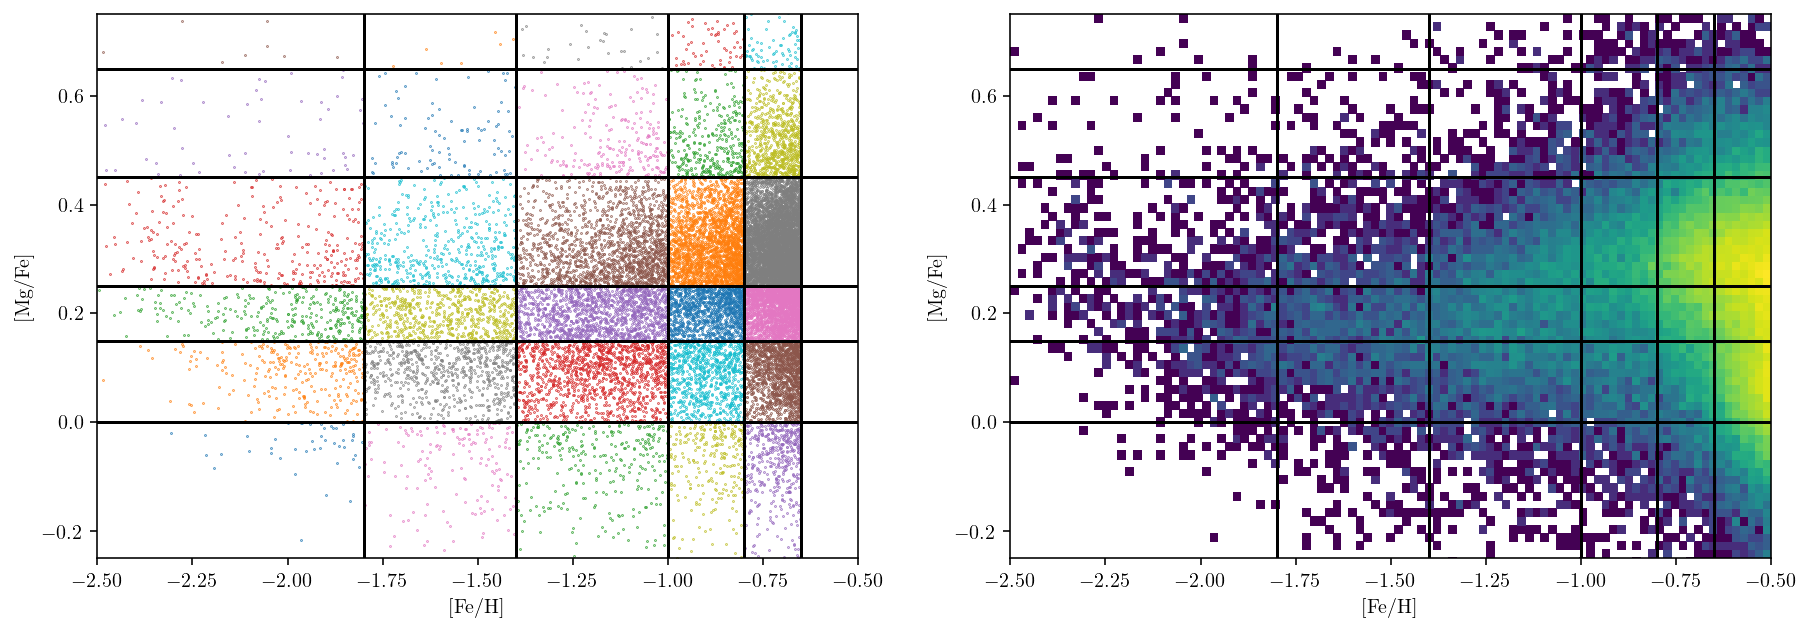

In [71]:
fe_h_cuts = [np.min(data['fe_h'][basic_cuts]),-1.80,-1.40,-1.0,-0.8,-0.65]
mg_fe_cuts = [np.min(data['Mg_fe'][basic_cuts]),0.00,0.15,0.25,0.45,0.65,np.max(data['Mg_fe'][basic_cuts])]

def get_initial_idea_of_needed_bins(fe_h_cuts, mg_fe_cuts):

    list_both = []
    in_bin_matrix = []

    for each_fe_h_bin,(each_fe_h_bin_min,each_fe_h_bin_max) in enumerate(zip(fe_h_cuts[:-1],fe_h_cuts[1:])):

        list_row = []

        for each_mg_fe_bin,(each_mg_fe_bin_min,each_mg_fe_bin_max) in enumerate(zip(mg_fe_cuts[:-1],mg_fe_cuts[1:])):

            in_bin = (
                basic_cuts &
                (data['fe_h'] >= each_fe_h_bin_min) &
                (data['fe_h'] <  each_fe_h_bin_max) &
                (data['Mg_fe'] >= each_mg_fe_bin_min) &
                (data['Mg_fe'] <  each_mg_fe_bin_max)
            )

            in_bin_matrix.append(in_bin)
            list_row.append(len(data['fe_h'][in_bin]))

        list_both.append(list_row)

    f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

    for each in fe_h_cuts[1:]:
        ax1.axvline(each,color='k')
        ax2.axvline(each,color='k')
    for each in mg_fe_cuts[1:-1]:
        ax1.axhline(each,color='k')
        ax2.axhline(each,color='k')
    for in_bin in in_bin_matrix:
        ax1.scatter(
            data['fe_h'][in_bin],
            data['Mg_fe'][in_bin],
            s=0.1
        )
    ax2.hist2d(
        data['fe_h'][basic_cuts],
        data['Mg_fe'][basic_cuts],
        bins=(np.linspace(-2.5,-0.5,100),np.linspace(-0.75,0.75,100)),
        cmin=1,norm=LogNorm()
    );

    ax1.set_xlim(-2.5,-0.5)
    ax2.set_xlim(-2.5,-0.5)
    ax1.set_ylim(-0.25,0.75)
    ax2.set_ylim(-0.25,0.75)
    
    ax1.set_xlabel(r'$\mathrm{[Fe/H]}$')
    ax1.set_ylabel(r'$\mathrm{[Mg/Fe]}$')
    ax2.set_xlabel(r'$\mathrm{[Fe/H]}$')
    ax2.set_ylabel(r'$\mathrm{[Mg/Fe]}$')

    print('Entries in each of the bins:')
    print((np.array(list_both).T)[::-1])

get_initial_idea_of_needed_bins(fe_h_cuts, mg_fe_cuts)

In [72]:
# basic_cuts: flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0
group = dict()
group['1'] = [-2.50,-1.80,-0.30,+0.65] # basic_cuts & fe_h >= -2.50 & fe_h < -1.80 & Mg_fe >= -0.30 & Mg_Fe < 0.65
group['2'] = [-1.80,-1.40,+0.25,+0.65] # basic_cuts & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.25 & Mg_Fe < 0.65
group['3'] = [-1.80,-1.40,+0.15,+0.25] # basic_cuts & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.15 & Mg_Fe < 0.25
group['4'] = [-1.80,-1.40,+0.00,+0.15] # basic_cuts & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.00 & Mg_Fe < 0.15
group['5'] = [-1.80,-0.80,-0.30,+0.00] # basic_cuts & fe_h >= -1.80 & fe_h < -0.80 & Mg_fe >= -0.30 & Mg_Fe < 0.00
group['6'] = [-1.40,-0.80,+0.45,+0.65] # basic_cuts & fe_h >= -1.40 & fe_h < -0.80 & Mg_fe >= 0.45 & Mg_Fe < 0.65
group['7'] = [-1.40,-1.00,+0.25,+0.45] # basic_cuts & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.25 & Mg_Fe < 0.45
group['8'] = [-1.40,-1.00,+0.15,+0.25] # basic_cuts & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.15 & Mg_Fe < 0.25
group['9'] = [-1.40,-1.00,+0.00,+0.15] # basic_cuts & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.00 & Mg_Fe < 0.15
group['10'] = [-1.00,-0.80,+0.25,+0.45] # basic_cuts & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.25 & Mg_Fe < 0.45
group['11'] = [-1.00,-0.80,+0.15,+0.25] # basic_cuts & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.15 & Mg_Fe < 0.25
group['12'] = [-1.00,-0.80,+0.00,+0.15] # basic_cuts & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.00 & Mg_Fe < 0.15
group['13'] = [-0.80,-0.65,+0.25,+0.45] # basic_cuts & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.25 & Mg_Fe < 0.45
group['14'] = [-0.80,-0.65,+0.15,+0.25] # basic_cuts & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.15 & Mg_Fe < 0.25
group['15'] = [-0.80,-0.65,+0.00,+0.15] # basic_cuts & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.00 & Mg_Fe < 0.15

In [73]:
in_group_mg = dict()
in_group_mgnacu = dict()

for each in group.keys():
    in_group_mg[each] = (
        basic_cuts &
        (data['fe_h'] >= group[each][0]) &
        (data['fe_h'] <  group[each][1]) &
        (data['Mg_fe'] >= group[each][2]) &
        (data['Mg_fe'] <  group[each][3])
    )
    in_group_mgnacu[each] = (
        basic_cuts_mgnacu &
        (data['fe_h'] >= group[each][0]) &
        (data['fe_h'] <  group[each][1]) &
        (data['Mg_fe'] >= group[each][2]) &
        (data['Mg_fe'] <  group[each][3])
    )

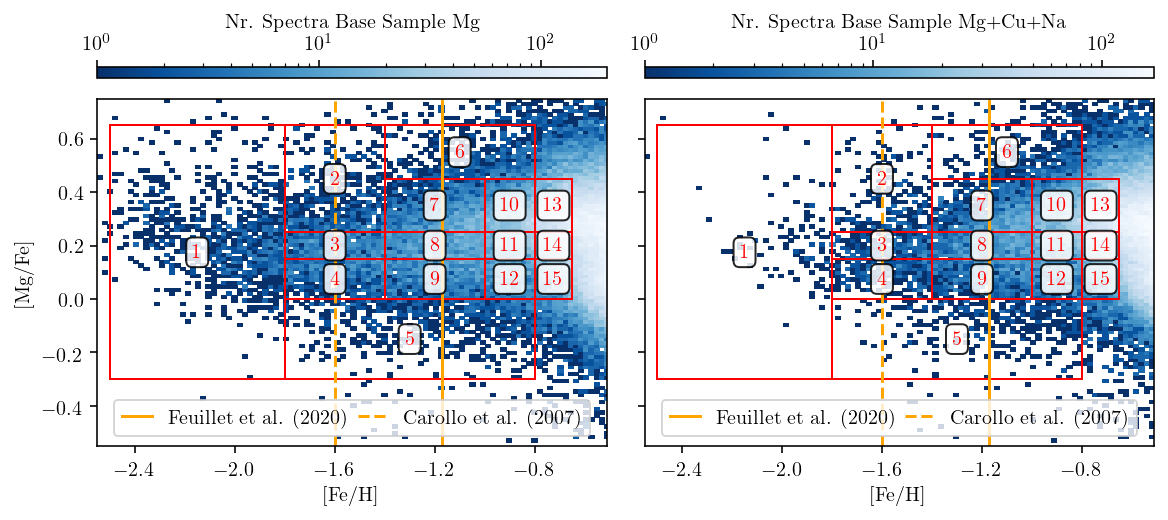

In [74]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5),sharex=True,sharey=True,constrained_layout=True)

ax=ax1

p,x,y,s = ax.hist2d(
    data['fe_h'][basic_cuts],
    data['Mg_fe'][basic_cuts],
    bins=(np.linspace(-2.55,-0.5,100),np.linspace(-0.55,0.75,100)),
    cmin=1,norm=LogNorm(),cmap='Blues_r'
);
c = plt.colorbar(s,ax=ax,location='top')
c.set_label('Nr. Spectra Base Sample Mg')

for each in group:
    ax.text(
        0.5*(group[each][0]+group[each][1]),
        0.5*(group[each][2]+group[each][3]),
        each,
        color='r',ha='center',va='center',
        bbox=dict(boxstyle='round', facecolor='w', alpha=0.85)
    )
    
    rect = patches.Rectangle((group[each][0], group[each][2]), group[each][1]-group[each][0], group[each][3]-group[each][2], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.axvline(-1.17,color='orange',label='Feuillet et al. (2020)')
ax.axvline(-1.6,color='orange',ls='dashed',label='Carollo et al. (2007)')
ax.legend(loc='lower center',ncol=2, handlelength=1.5,columnspacing=0.5)
ax.set_xlabel(r'$\mathrm{[Fe/H]}$')
ax.set_ylabel(r'$\mathrm{[Mg/Fe]}$')

ax=ax2
p,x,y,s = ax.hist2d(
    data['fe_h'][basic_cuts_mgnacu],
    data['Mg_fe'][basic_cuts_mgnacu],
    bins=(np.linspace(-2.55,-0.51,100),np.linspace(-0.55,0.75,100)),
    cmin=1,norm=LogNorm(),cmap='Blues_r'
);
c = f.colorbar(s,ax=ax,location='top')
c.set_label('Nr. Spectra Base Sample Mg+Cu+Na')

for each in group:
    ax.text(
        0.5*(group[each][0]+group[each][1]),
        0.5*(group[each][2]+group[each][3]),
        each,
        color='r',ha='center',va='center',
        bbox=dict(boxstyle='round', facecolor='w', alpha=0.85)
    )
    
    rect = patches.Rectangle((group[each][0], group[each][2]), group[each][1]-group[each][0], group[each][3]-group[each][2], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.axvline(-1.17,color='orange',label='Feuillet et al. (2020)')
ax.axvline(-1.6,color='orange',ls='dashed',label='Carollo et al. (2007)')
ax.legend(loc='lower center',ncol=2,handlelength=1.5,columnspacing=0.5)
ax.set_xlabel(r'$\mathrm{[Fe/H]}$')

ax.set_xticks([-2.4,-2.0,-1.6,-1.2,-0.8])

#ax.set_ylabel(r'$\mathrm{[Mg/Fe]}$')
#plt.tight_layout()
plt.savefig('maps_feh_mgfe.png',dpi=300,bbox_inches='tight')

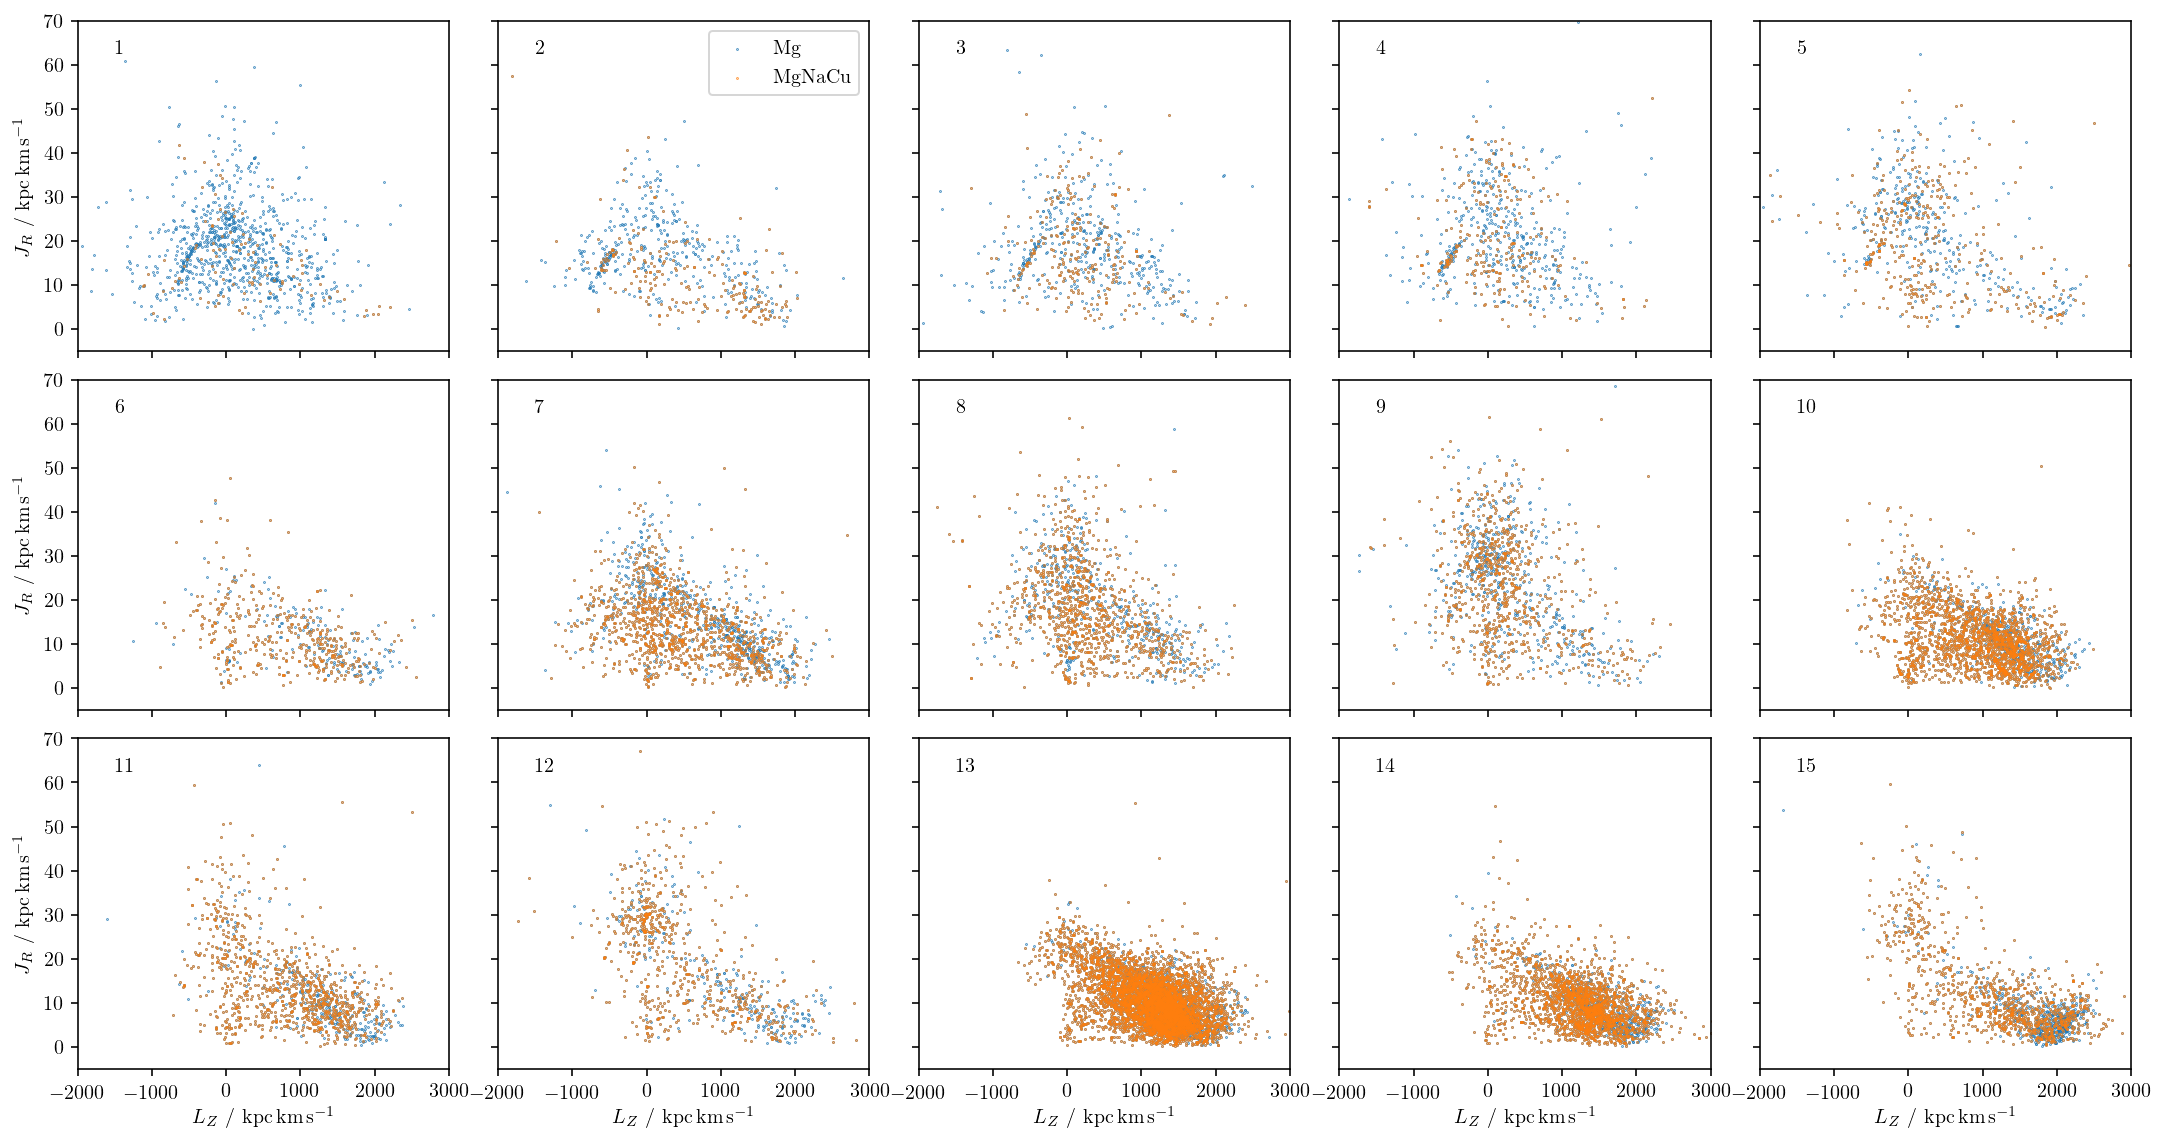

In [75]:
def plot_jr_lz(data):

    f, gs = plt.subplots(3,5,figsize=(15,8),sharex=True,sharey=True)

    for each in group.keys():
        
        each_index = int(each)-1
        
        if each_index < 5:
            ax=gs[0,each_index]
        elif (each_index >= 5) & (each_index < 10):
            ax=gs[1,each_index-5]
        else:
            ax=gs[2,each_index-10]

        ax.scatter(
            data['L_Z'][in_group_mg[each]],
            np.sqrt(data['J_R'][in_group_mg[each]]),
            label='Mg',
            s=0.1
        )
        ax.scatter(
            data['L_Z'][in_group_mgnacu[each]],
            np.sqrt(data['J_R'][in_group_mgnacu[each]]),
            label='MgNaCu',
            s=0.1
        )

        ax.set_xlim(-2000,3000)
        ax.set_ylim(-5,70)
        ax.text(0.1,0.9,each,transform=ax.transAxes)
        if each=='2':
            ax.legend()
        if each_index>=10:
            ax.set_xlabel(r'$L_Z$ / $\mathrm{kpc\,km\,s^{-1}}$')
        if each_index in [0,5,10]:
            ax.set_ylabel(r'$J_R$ / $\mathrm{kpc\,km\,s^{-1}}$')
    plt.tight_layout()
plot_jr_lz(data)
plt.savefig('maps_feh_mgfe_dynamics_lzjr.png',dpi=300,bbox_inches='tight')

GSE: 4, 5, 8, 9, 11?, 12, 15

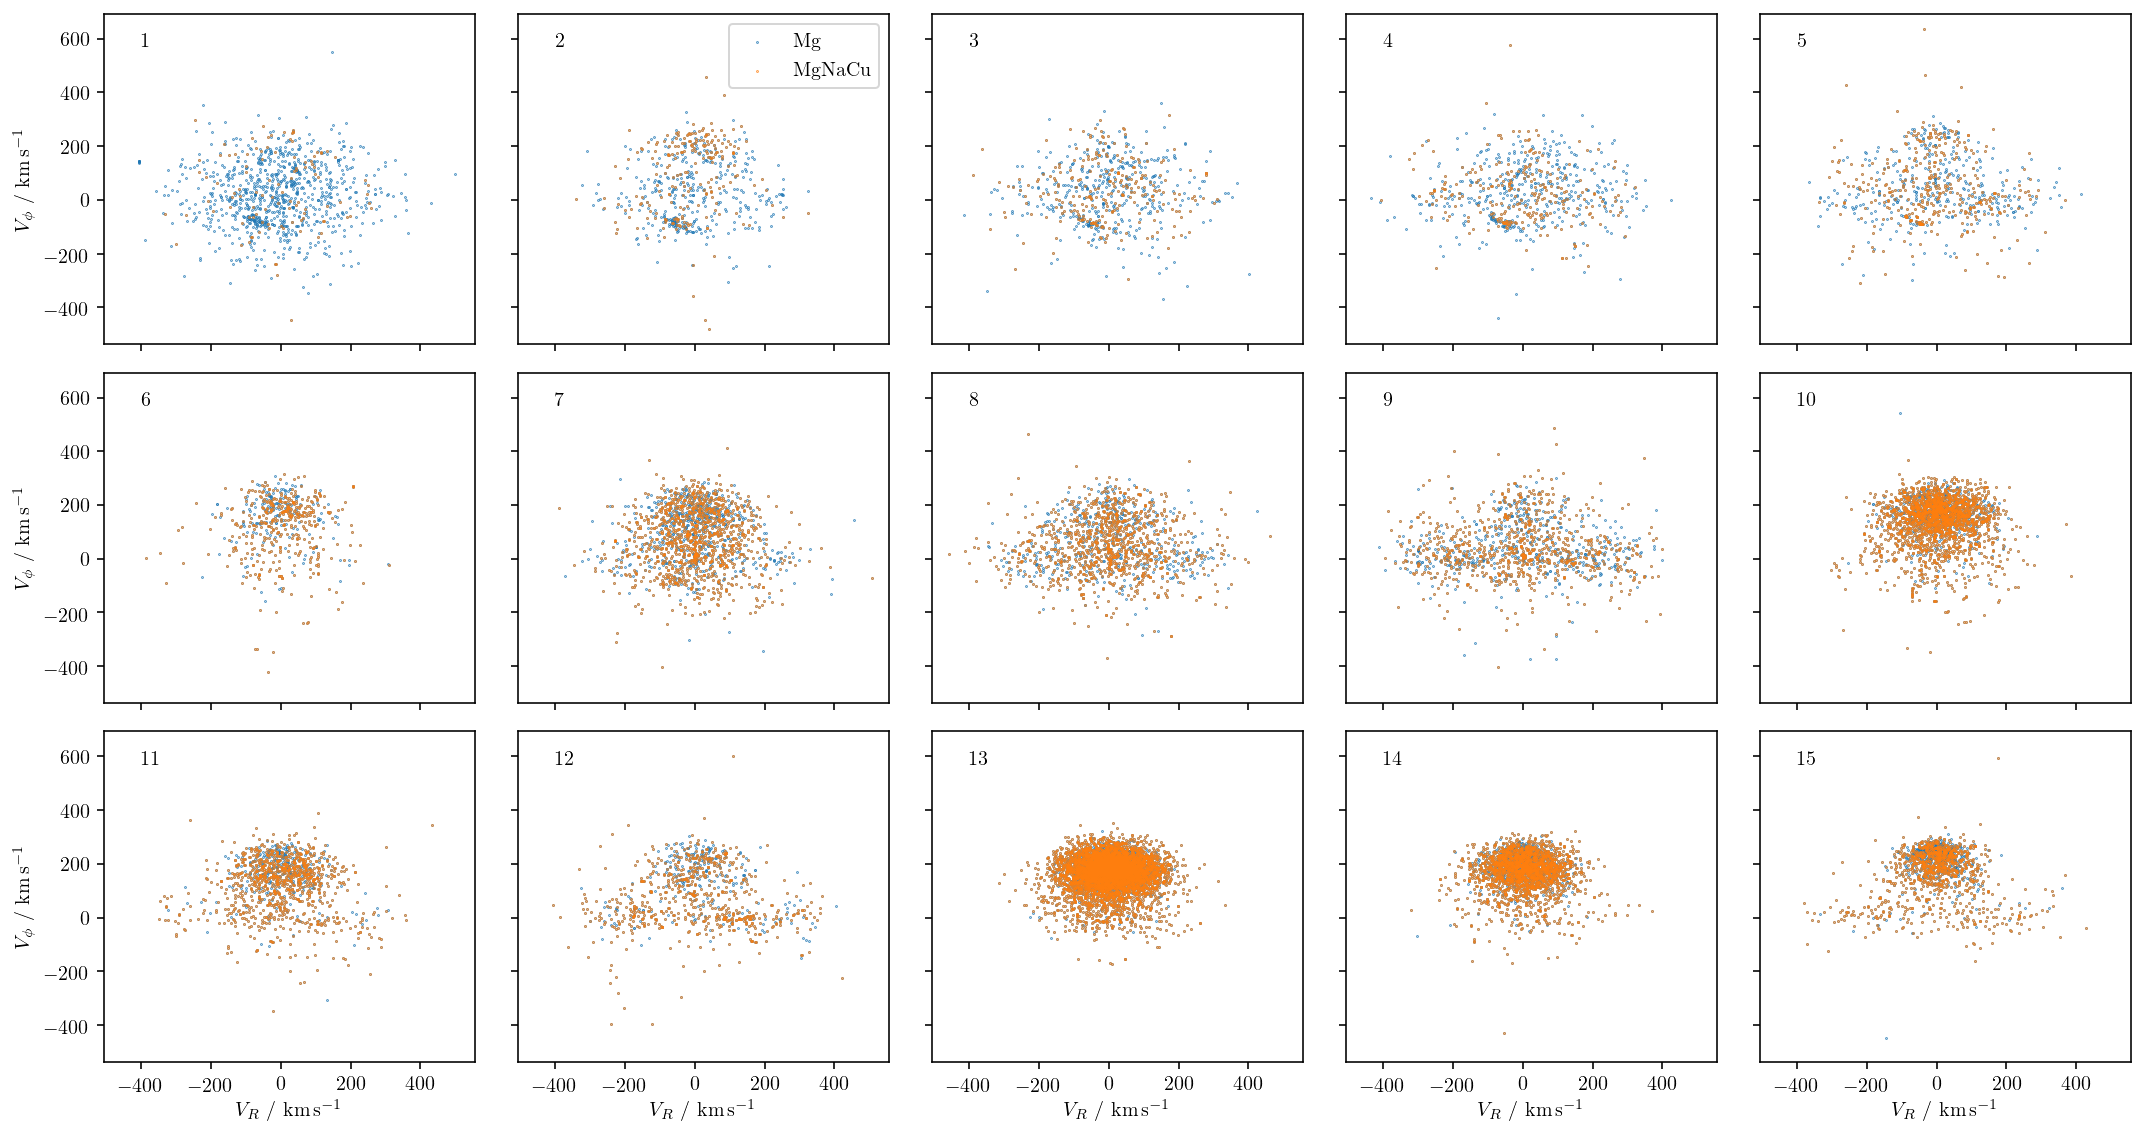

In [76]:
def plot_vr_vphi(data):

    f, gs = plt.subplots(3,5,figsize=(15,8),sharex=True,sharey=True)

    for each in group.keys():
        
        each_index = int(each)-1
        
        if each_index < 5:
            ax=gs[0,each_index]
        elif (each_index >= 5) & (each_index < 10):
            ax=gs[1,each_index-5]
        else:
            ax=gs[2,each_index-10]

        ax.scatter(
            data['vR_Rzphi'][in_group_mg[each]],
            data['vT_Rzphi'][in_group_mg[each]],
            label='Mg',
            s=0.1
        )
        ax.scatter(
            data['vR_Rzphi'][in_group_mgnacu[each]],
            data['vT_Rzphi'][in_group_mgnacu[each]],
            label='MgNaCu',
            s=0.1
        )

        #ax.set_xlim(-2000,3000)
        #ax.set_ylim(-5,70)
        ax.text(0.1,0.9,each,transform=ax.transAxes)
        
        if each=='2':
            ax.legend()
        if each_index>=10:
            ax.set_xlabel(r'$V_R$ / $\mathrm{km\,s^{-1}}$')
        if each_index in [0,5,10]:
            ax.set_ylabel(r'$V_\phi$ / $\mathrm{km\,s^{-1}}$')
    plt.tight_layout()
        
plot_vr_vphi(data)
plt.savefig('maps_feh_mgfe_dynamics_vrvphi.png',dpi=300,bbox_inches='tight')

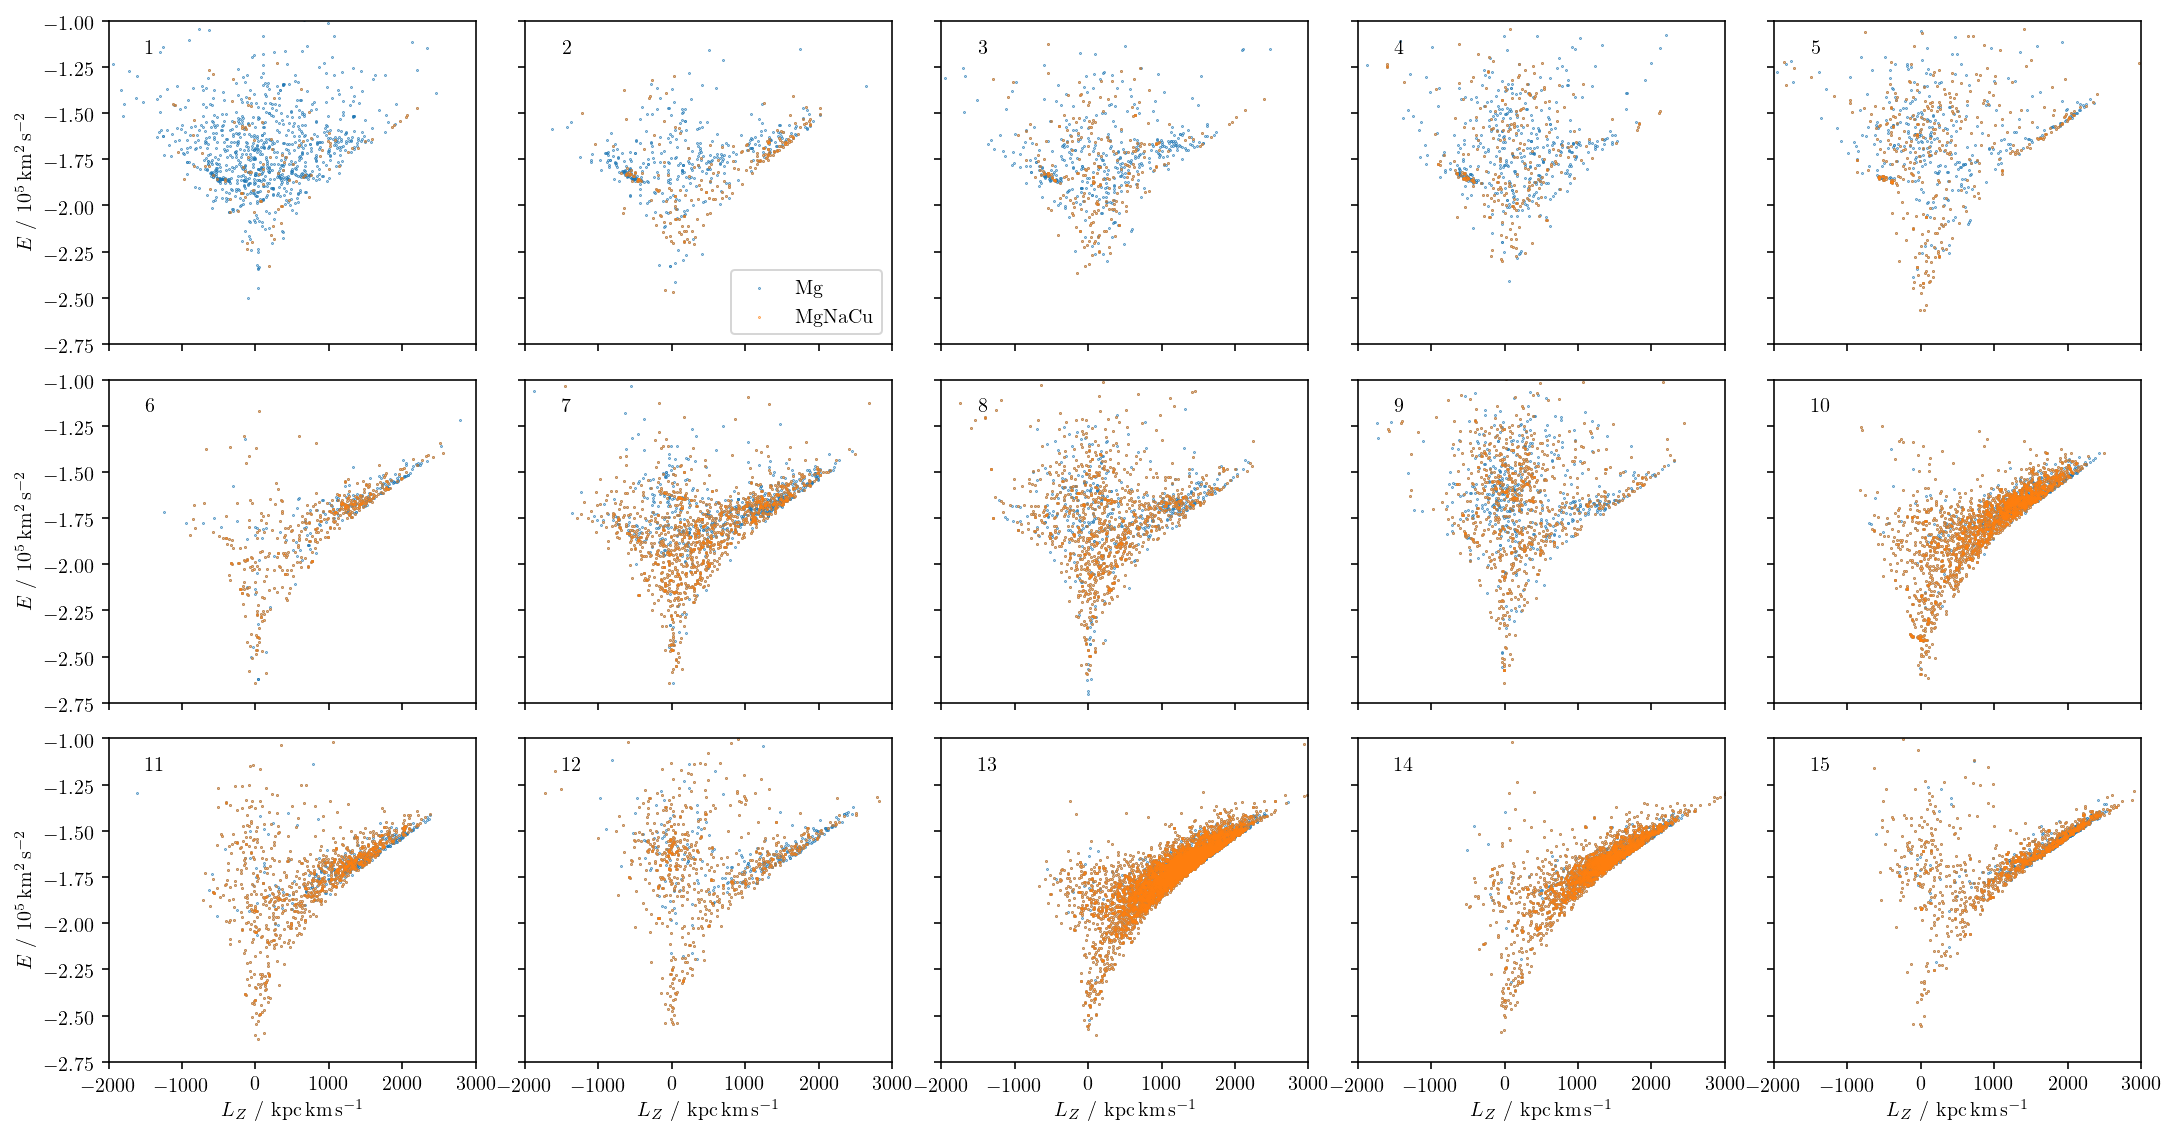

In [77]:
def plot_lz_e(data):

    f, gs = plt.subplots(3,5,figsize=(15,8),sharex=True,sharey=True)

    for each in group.keys():
        
        each_index = int(each)-1
        
        if each_index < 5:
            ax=gs[0,each_index]
        elif (each_index >= 5) & (each_index < 10):
            ax=gs[1,each_index-5]
        else:
            ax=gs[2,each_index-10]

        ax.scatter(
            data['L_Z'][in_group_mg[each]],
            data['Energy'][in_group_mg[each]]/10**5,
            label='Mg',
            s=0.1
        )
        ax.scatter(
            data['L_Z'][in_group_mgnacu[each]],
            data['Energy'][in_group_mgnacu[each]]/10**5,
            label='MgNaCu',
            s=0.1
        )

        ax.set_xlim(-2000,3000)
        ax.set_ylim(-2.75,-1.0)
        ax.text(0.1,0.9,each,transform=ax.transAxes)
        if each=='2':
            ax.legend()
        if each_index>=10:
            ax.set_xlabel(r'$L_Z$ / $\mathrm{kpc\,km\,s^{-1}}$')
        if each_index in [0,5,10]:
            ax.set_ylabel(r'$E$ / $10^5\,\mathrm{km^{2}\,s^{-2}}$')
    plt.tight_layout()
    
plot_lz_e(data)
plt.savefig('maps_feh_mgfe_dynamics_lze.png',dpi=300,bbox_inches='tight')

In [78]:
# topcat -stilts plot2plane \
#    xpix=886 ypix=399 \
#    xlabel='[Fe/H]' ylabel='[Mg/Fe]' texttype=latex \
#    xmin=-2.5 xmax=-0.5 ymin=-0.4 ymax=0.8 \
#    legend=true legpos=0.0,1.0 \
#    in=/Users/svenbuder/galah_accreted_chemistry/data/GALAH_DR3_all_joined_v2.fits x=fe_h y=Mg_fe \
#     shading=auto axis=Vertical \
#    layer_01=Mark \
#       icmd_01='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0"' \
#       color_01=light_grey \
#       leglabel_01=basic_cuts \
#    layer_02=Mark \
#       icmd_02='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -2.25 & fe_h < -1.80 & Mg_fe >= -0.30 & Mg_Fe < 0.65"' \
#       color_02=cyan \
#       leglabel_02='1: group1' \
#    layer_03=Mark \
#       icmd_03='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.25 & Mg_Fe < 0.65"' \
#       color_03=orange \
#       leglabel_03='1: group2' \
#    layer_04=Mark \
#       icmd_04='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.15 & Mg_Fe < 0.25"' \
#       color_04=pink \
#       leglabel_04='1: group3' \
#    layer_05=Mark \
#       icmd_05='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.80 & fe_h < -1.40 & Mg_fe >= 0.00 & Mg_Fe < 0.15"' \
#       color_05=yellow \
#       leglabel_05='1: group4' \
#    layer_06=Mark \
#       icmd_06='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.80 & fe_h < -0.80 & Mg_fe >= -0.30 & Mg_Fe < 0.00"' \
#       leglabel_06='1: group5' \
#    layer_07=Mark \
#       icmd_07='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.40 & fe_h < -0.80 & Mg_fe >= 0.45 & Mg_Fe < 0.65"' \
#       color_07=blue \
#       leglabel_07='1: group6' \
#    layer_08=Mark \
#       icmd_08='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.25 & Mg_Fe < 0.45"' \
#       color_08=green \
#       leglabel_08='1: group7' \
#    layer_09=Mark \
#       icmd_09='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.15 & Mg_Fe < 0.25"' \
#       color_09=grey \
#       leglabel_09='1: group8' \
#    layer_10=Mark \
#       icmd_10='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.40 & fe_h < -1.00 & Mg_fe >= 0.00 & Mg_Fe < 0.15"' \
#       color_10=magenta \
#       leglabel_10='1: group9' \
#    layer_11=Mark \
#       icmd_11='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.25 & Mg_Fe < 0.45"' \
#       color_11=cyan \
#       leglabel_11='1: group10' \
#    layer_12=Mark \
#       icmd_12='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.15 & Mg_Fe < 0.25"' \
#       color_12=orange \
#       leglabel_12='1: group11' \
#    layer_13=Mark \
#       icmd_13='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -1.00 & fe_h < -0.80 & Mg_fe >= 0.00 & Mg_Fe < 0.15"' \
#       color_13=pink \
#       leglabel_13='1: group12' \
#    layer_14=Mark \
#       icmd_14='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.25 & Mg_Fe < 0.45"' \
#       color_14=yellow \
#       leglabel_14='1: group13' \
#    layer_15=Mark \
#       icmd_15='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.15 & Mg_Fe < 0.25"' \
#       leglabel_15='1: group14' \
#    layer_16=Mark \
#       icmd_16='select "flag_sp == 0 & flag_Na_fe == 0 & flag_Mg_fe == 0 & flag_Cu_fe == 0 & abs(L_Z) >= 0 & fe_h >= -0.80 & fe_h < -0.65 & Mg_fe >= 0.00 & Mg_Fe < 0.15"' \
#       color_16=blue \
#       leglabel_16='1: group15' \
#    layer_17=Function \
#       fexpr_17=-1.6 color_17=blue thick_17=2 dash_17=8,4 antialias_17=true \
#       leglabel_17='Carollo\,et\,al.\,(2007)' \
#    layer_18=Function \
#       fexpr_18=-1.17 thick_18=3 \
#       leglabel_18='Feuillet\,et\,al.\,(2020)' 